# Part 3: visualization
done by yours truly.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
file_path = "C:/Users/archi/Desktop/youtube-views-prediction/src/data_collection/datasets/cleaned_video_data.csv"
df = pd.read_csv("C:/Users/archi/Desktop/youtube-views-prediction/src/data_collection/datasets/cleaned_video_data.csv")

# Display the first few rows of the DataFrame to get an overview of the data
print(df.head())

  upload_date  viewCount  likeCount  commentCount  duration_seconds
0  01/03/2024      41344       1580           180               219
1  01/03/2024      49941       1967           182               217
2  01/03/2024     156400      10674           778               301
3  01/02/2024     725594      21333          1076               321
4  01/02/2024     294807      13111            89                31


### As we can see, the clean data is still here. Let's get visualizing it.

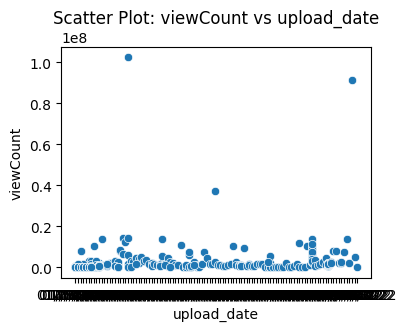

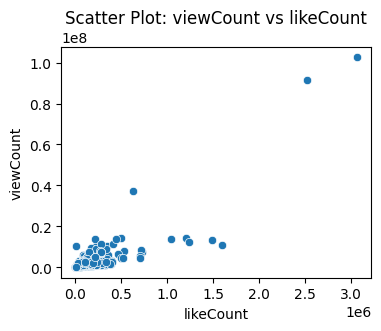

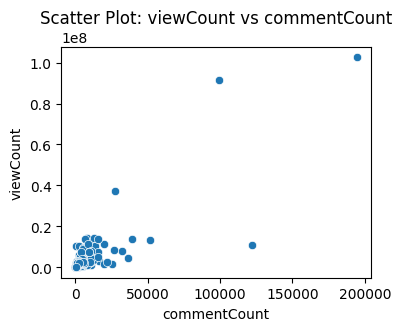

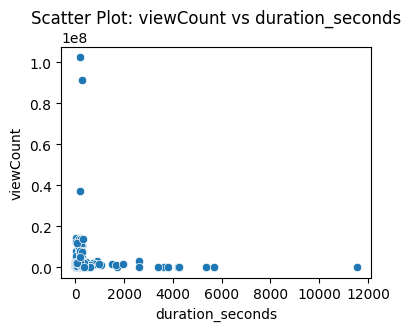

In [2]:
# Create a folder to save the plots if it doesn't exist
output_folder = "../reports/figures"
os.makedirs(output_folder, exist_ok=True)

# Function to create scatter plot and save it
def create_scatter_plot(x_col, y_col):
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=x_col, y=y_col, data=df)
    plt.title(f'Scatter Plot: {y_col} vs {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    # Save the plot in the output folder
    output_path = os.path.join(output_folder, f'scatter_{y_col}_vs_{x_col}.png')
    plt.savefig(output_path)
    
    plt.show()

# Iterate through each column (excluding 'viewCount') and create scatter plots
target_col = 'viewCount'
for col in df.columns:
    if col != target_col:
        create_scatter_plot(col, target_col)


### Not particularly useful. That means that we have to standardize data first:

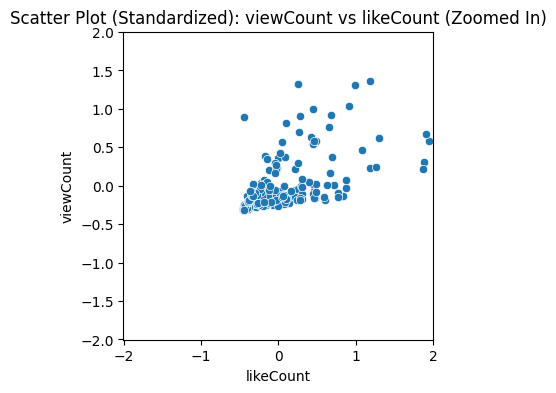

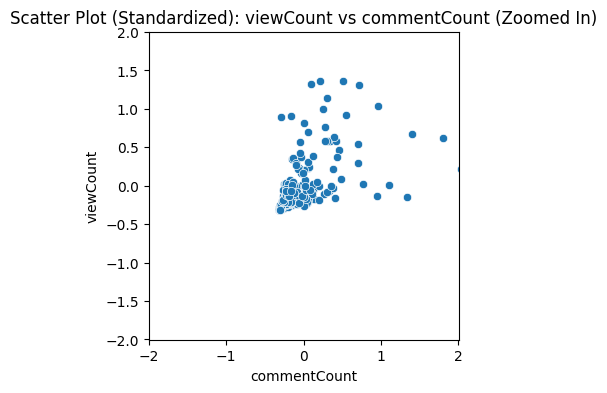

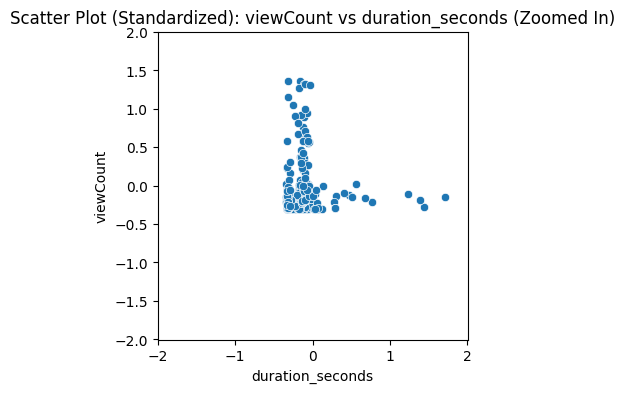

In [3]:
from sklearn.preprocessing import StandardScaler

# Copy the original DataFrame to keep the original data
df_standardized = df.copy()

# Standardize all columns except the target ('viewCount')
scaler = StandardScaler()
df_standardized[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])

# Convert 'upload_date' to datetime type if it's not already
df_standardized['upload_date'] = pd.to_datetime(df_standardized['upload_date'], errors='coerce')

# Calculate the number of days since the minimum date in 'upload_date'
df_standardized['days_since_upload'] = (df_standardized['upload_date'] - df_standardized['upload_date'].min()).dt.days

# Function to create scatter plot after standardization with zoomed-in view
def create_zoomed_scatter_plot(x_col, y_col, xlim_factor=2, ylim_factor=2):
    plt.figure(figsize=(4, 4))
    
    # Use xlim and ylim based on standard deviation to exclude outliers
    xlim = (df_standardized[x_col].mean() - xlim_factor * df_standardized[x_col].std(),
            df_standardized[x_col].mean() + xlim_factor * df_standardized[x_col].std())
    ylim = (df_standardized[y_col].mean() - ylim_factor * df_standardized[y_col].std(),
            df_standardized[y_col].mean() + ylim_factor * df_standardized[y_col].std())
    
    sns.scatterplot(x=x_col, y=y_col, data=df_standardized)
    plt.title(f'Scatter Plot (Standardized): {y_col} vs {x_col} (Zoomed In)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # Save the plot in the output folder
    output_path = os.path.join(output_folder, f'scatter_standardized_zoomed_{y_col}_vs_{x_col}.png')
    plt.savefig(output_path)
    
    plt.show()

# Iterate through each column (excluding 'viewCount' and 'upload_date') and create standardized scatter plots with zoomed-in view
for col in df.columns:
    if col != target_col and col != 'upload_date':
        create_zoomed_scatter_plot(col, target_col)

### Due to the tight grouping of the data, we can definitely see a trend in some of these graphs. Let's investigate it more with regression analysis.

# Part 4: Regression analysis

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


# Function to perform regression, calculate R-squared, and plot regression graph
def perform_regression_with_plot(model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} R-squared: {r2:.4f}")
    
    # Plot regression graph
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)
    plt.title(f'{model_name} Regression')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()
    
    return r2

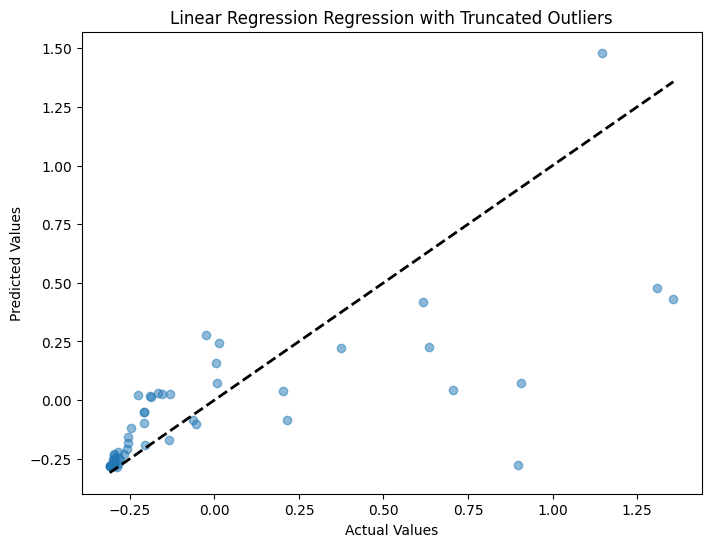

Linear Regression R-squared (Truncated): 0.5268


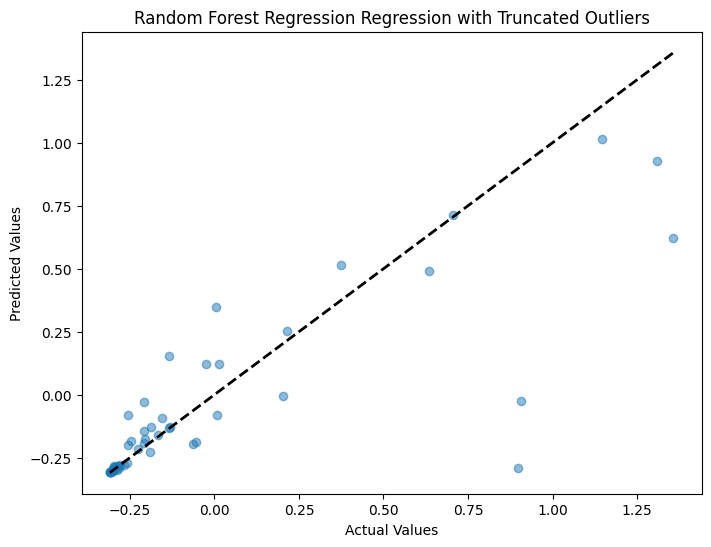

Random Forest Regression R-squared (Truncated): 0.6658


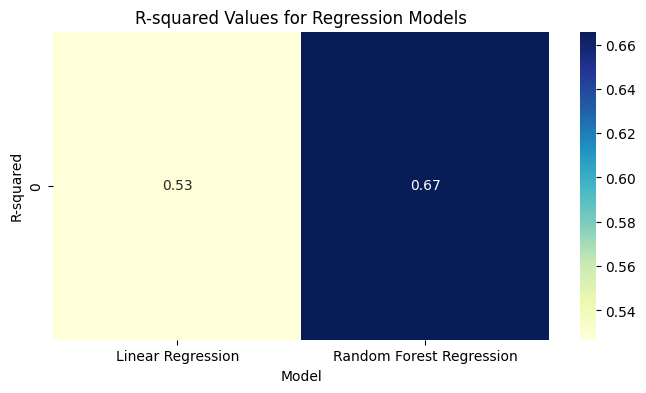

In [15]:
# Function to perform regression, calculate R-squared, and plot regression graph with truncated outliers
def perform_regression_with_plot_and_truncation(model, model_name, X, y, truncation_factor=0.95):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate the lower and upper limits for truncation based on residuals
    lower_limit = np.percentile(residuals, (1 - truncation_factor) / 2 * 100)
    upper_limit = np.percentile(residuals, (1 + truncation_factor) / 2 * 100)
    
    # Truncate outliers for better visualization
    y_test_truncated = y_test[(residuals >= lower_limit) & (residuals <= upper_limit)]
    y_pred_truncated = y_pred[(residuals >= lower_limit) & (residuals <= upper_limit)]
    
    # Plot regression graph with truncated outliers
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_truncated, y_pred_truncated, alpha=0.5)
    plt.plot([min(y_test_truncated), max(y_test_truncated)], [min(y_test_truncated), max(y_test_truncated)], '--k', linewidth=2)
    plt.title(f'{model_name} Regression with Truncated Outliers')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()
    
    # Calculate R-squared for truncated data
    r2 = r2_score(y_test_truncated, y_pred_truncated)
    print(f"{model_name} R-squared (Truncated): {r2:.4f}")
    
    return r2

# 2.2.1 Linear Regression
linear_reg_model = LinearRegression()
linear_reg_r2 = perform_regression_with_plot_and_truncation(linear_reg_model, "Linear Regression", X, y)

# 2.2.2 Random Forest Regression
rf_reg_model = RandomForestRegressor(random_state=42)
rf_reg_r2 = perform_regression_with_plot_and_truncation(rf_reg_model, "Random Forest Regression", X, y)

# Combine R-squared values for plotting
r2_values = {'Linear Regression': linear_reg_r2, 'Random Forest Regression': rf_reg_r2}

# 2.4 Plot a heatmap for R-squared values
plt.figure(figsize=(8, 4))
sns.heatmap([list(r2_values.values())], annot=True, cmap="YlGnBu", xticklabels=list(r2_values.keys()))
plt.title('R-squared Values for Regression Models')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.show()


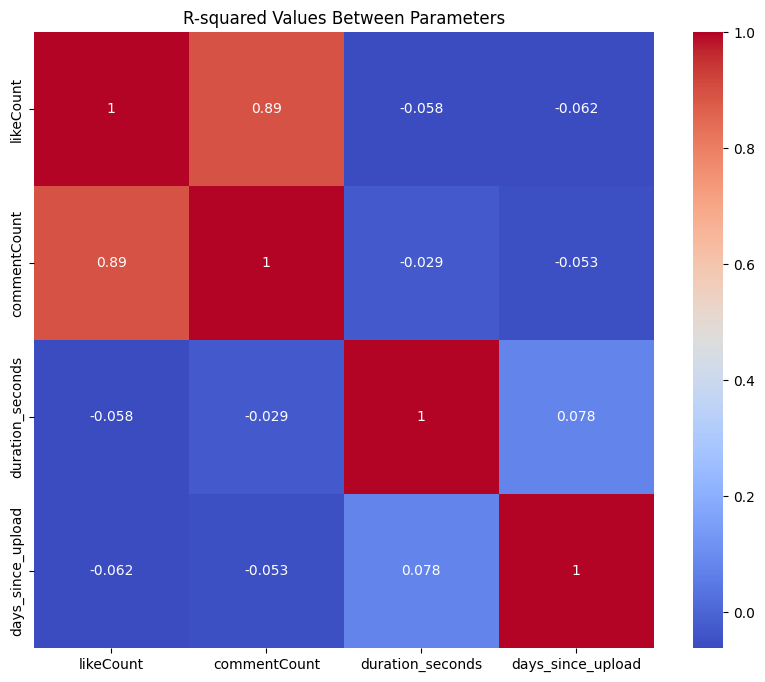

In [19]:
# Calculate the correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", xticklabels=X.columns, yticklabels=X.columns)
plt.title('R-squared Values Between Parameters')
plt.show()

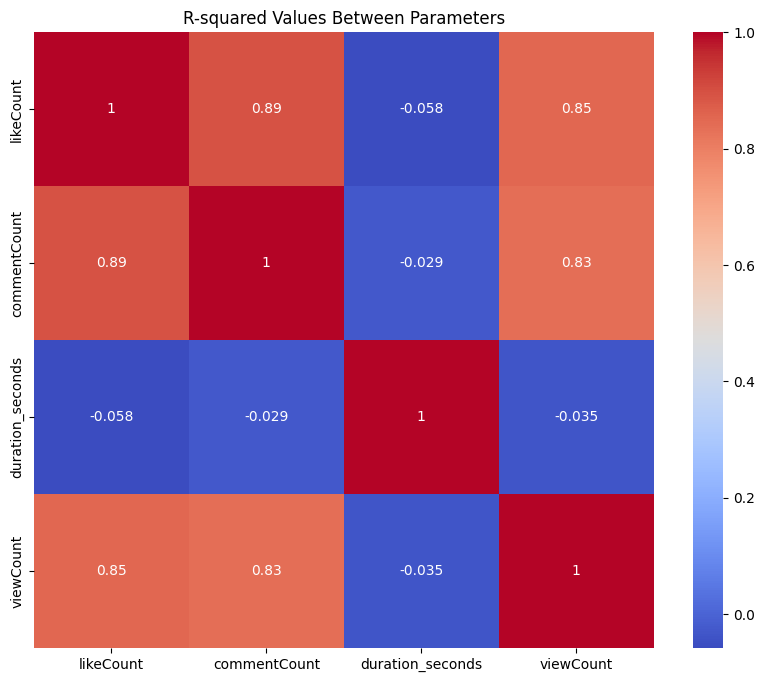

In [24]:
# Exclude 'upload_date' from the X DataFrame if it contains string values
X_with_viewCount = df[['likeCount', 'commentCount', 'duration_seconds', 'viewCount']]

# Convert 'upload_date' to datetime if it's a date column
df['upload_date'] = pd.to_datetime(df['upload_date'], errors='coerce')

# Calculate the correlation matrix including 'viewCount'
corr_matrix = np.corrcoef(X_with_viewCount, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", xticklabels=X_with_viewCount.columns, yticklabels=X_with_viewCount.columns)
plt.title('R-squared Values Between Parameters')
plt.show()
